# Parallel Monto-Carlo options pricing

This notebook shows how to use `ipyparallel` to do Monte-Carlo options pricing in parallel. We will compute the price of a large number of options for different strike prices and volatilities.

## Problem setup

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import sys
import time
import numpy as np

Here are the basic parameters for our computation.

In [3]:
price = 100.0  # Initial price
rate = 0.05  # Interest rate
days = 260  # Days to expiration
paths = 10000  # Number of MC paths
n_strikes = 6  # Number of strike values
min_strike = 90.0  # Min strike price
max_strike = 110.0  # Max strike price
n_sigmas = 5  # Number of volatility values
min_sigma = 0.1  # Min volatility
max_sigma = 0.4  # Max volatility

In [4]:
strike_vals = np.linspace(min_strike, max_strike, n_strikes)
sigma_vals = np.linspace(min_sigma, max_sigma, n_sigmas)

In [5]:
from __future__ import print_function # legacy Python support
print("Strike prices: ", strike_vals)
print("Volatilities: ", sigma_vals)

Strike prices:  [  90.   94.   98.  102.  106.  110.]
Volatilities:  [ 0.1    0.175  0.25   0.325  0.4  ]


## Monte-Carlo option pricing function

The following function computes the price of a single option.  It returns the call and put prices for both European and Asian style options.

In [6]:
def price_option(S=100.0, K=100.0, sigma=0.25, r=0.05, days=260, paths=10000):
    """
    Price European and Asian options using a Monte Carlo method.

    Parameters
    ----------
    S : float
        The initial price of the stock.
    K : float
        The strike price of the option.
    sigma : float
        The volatility of the stock.
    r : float
        The risk free interest rate.
    days : int
        The number of days until the option expires.
    paths : int
        The number of Monte Carlo paths used to price the option.

    Returns
    -------
    A tuple of (E. call, E. put, A. call, A. put) option prices.
    """
    import numpy as np
    from math import exp,sqrt
    
    h = 1.0/days
    const1 = exp((r-0.5*sigma**2)*h)
    const2 = sigma*sqrt(h)
    stock_price = S*np.ones(paths, dtype='float64')
    stock_price_sum = np.zeros(paths, dtype='float64')
    for j in range(days):
        growth_factor = const1*np.exp(const2*np.random.standard_normal(paths))
        stock_price = stock_price*growth_factor
        stock_price_sum = stock_price_sum + stock_price
    stock_price_avg = stock_price_sum/days
    zeros = np.zeros(paths, dtype='float64')
    r_factor = exp(-r*h*days)
    euro_put = r_factor*np.mean(np.maximum(zeros, K-stock_price))
    asian_put = r_factor*np.mean(np.maximum(zeros, K-stock_price_avg))
    euro_call = r_factor*np.mean(np.maximum(zeros, stock_price-K))
    asian_call = r_factor*np.mean(np.maximum(zeros, stock_price_avg-K))
    return (euro_call, euro_put, asian_call, asian_put)

We can time a single call of this function using the `%timeit` magic:

In [7]:
%time result = price_option(S=100.0, K=100.0, sigma=0.25, r=0.05, days=260, paths=10000)
result

CPU times: user 174 ms, sys: 5.96 ms, total: 180 ms
Wall time: 211 ms


(12.166236181100073,
 7.6440122060909745,
 6.8409606562778666,
 4.4639448434953621)

## Parallel computation across strike prices and volatilities

The Client is used to setup the calculation and works with all engines.

In [8]:
import ipyparallel as ipp
rc = ipp.Client()

A `LoadBalancedView` is an interface to the engines that provides dynamic load
balancing at the expense of not knowing which engine will execute the code.

In [9]:
view = rc.load_balanced_view()

Submit tasks for each (strike, sigma) pair. Again, we use the `%%timeit` magic to time the entire computation.

In [10]:
async_results = []

In [11]:
%%time

for strike in strike_vals:
    for sigma in sigma_vals:
        # This line submits the tasks for parallel computation.
        ar = view.apply_async(price_option, price, strike, sigma, rate, days, paths)
        async_results.append(ar)

rc.wait(async_results)  # Wait until all tasks are done.

CPU times: user 127 ms, sys: 15.7 ms, total: 143 ms
Wall time: 1.97 s


In [12]:
len(async_results)

30

## Process and visualize results

Retrieve the results using the `get` method:

In [13]:
results = [ar.get() for ar in async_results]

Assemble the result into a structured NumPy array.

In [14]:
prices = np.empty(n_strikes*n_sigmas,
    dtype=[('ecall',float),('eput',float),('acall',float),('aput',float)]
)

for i, price in enumerate(results):
    prices[i] = tuple(price)

prices.shape = (n_strikes, n_sigmas)

Plot the value of the European call in (volatility, strike) space.

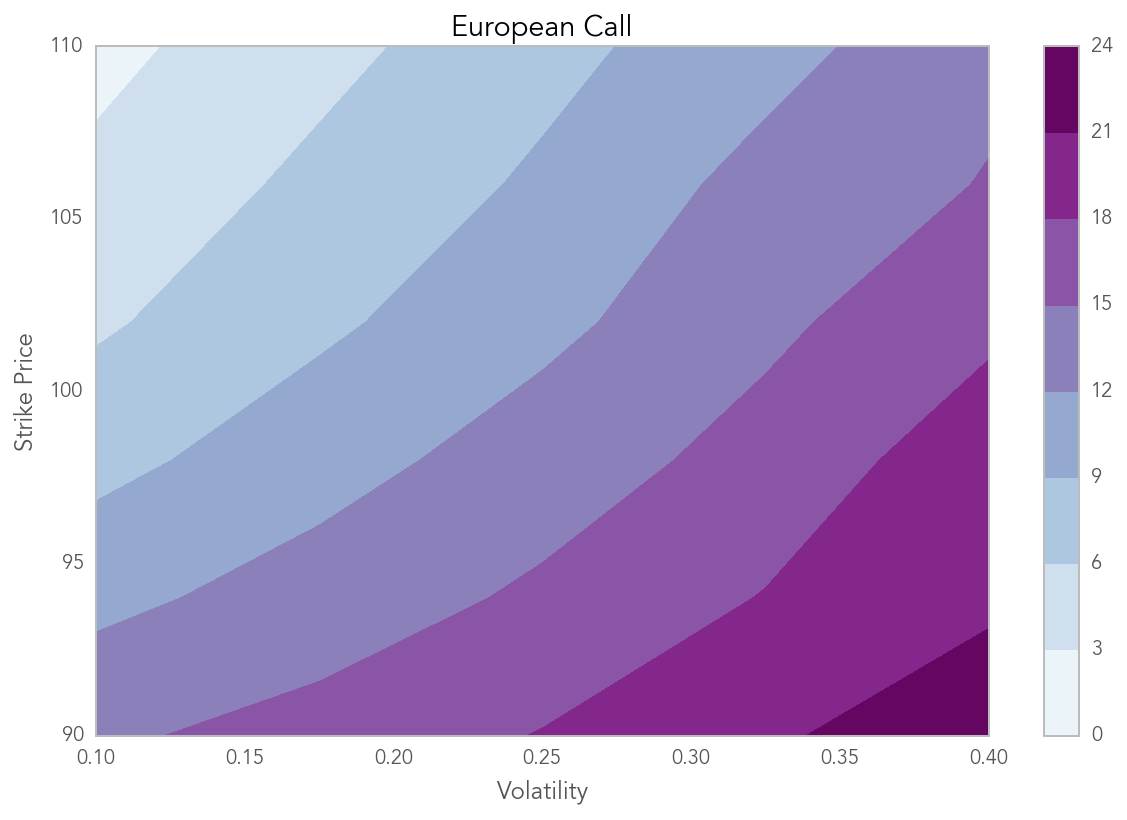

In [15]:
plt.figure()
plt.contourf(sigma_vals, strike_vals, prices['ecall'])
plt.axis('tight')
plt.colorbar()
plt.title('European Call')
plt.xlabel("Volatility")
plt.ylabel("Strike Price")

Plot the value of the Asian call in (volatility, strike) space.

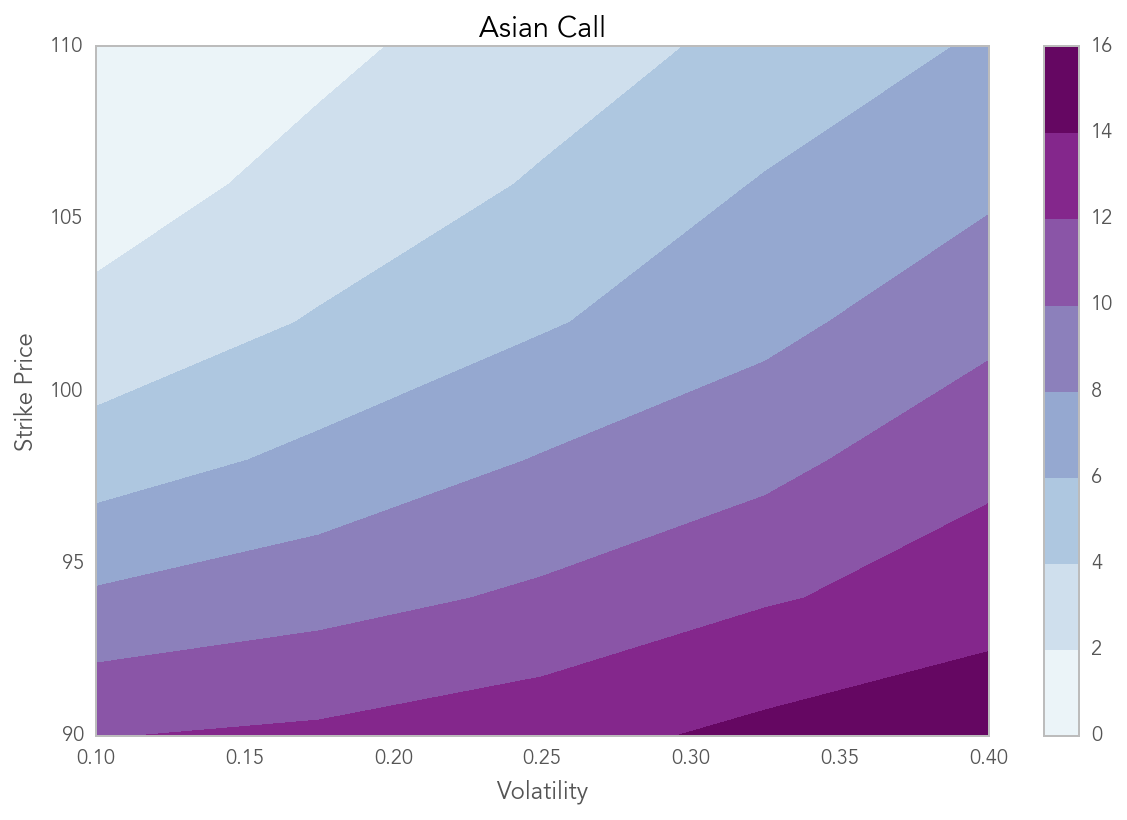

In [16]:
plt.figure()
plt.contourf(sigma_vals, strike_vals, prices['acall'])
plt.axis('tight')
plt.colorbar()
plt.title("Asian Call")
plt.xlabel("Volatility")
plt.ylabel("Strike Price")

Plot the value of the European put in (volatility, strike) space.

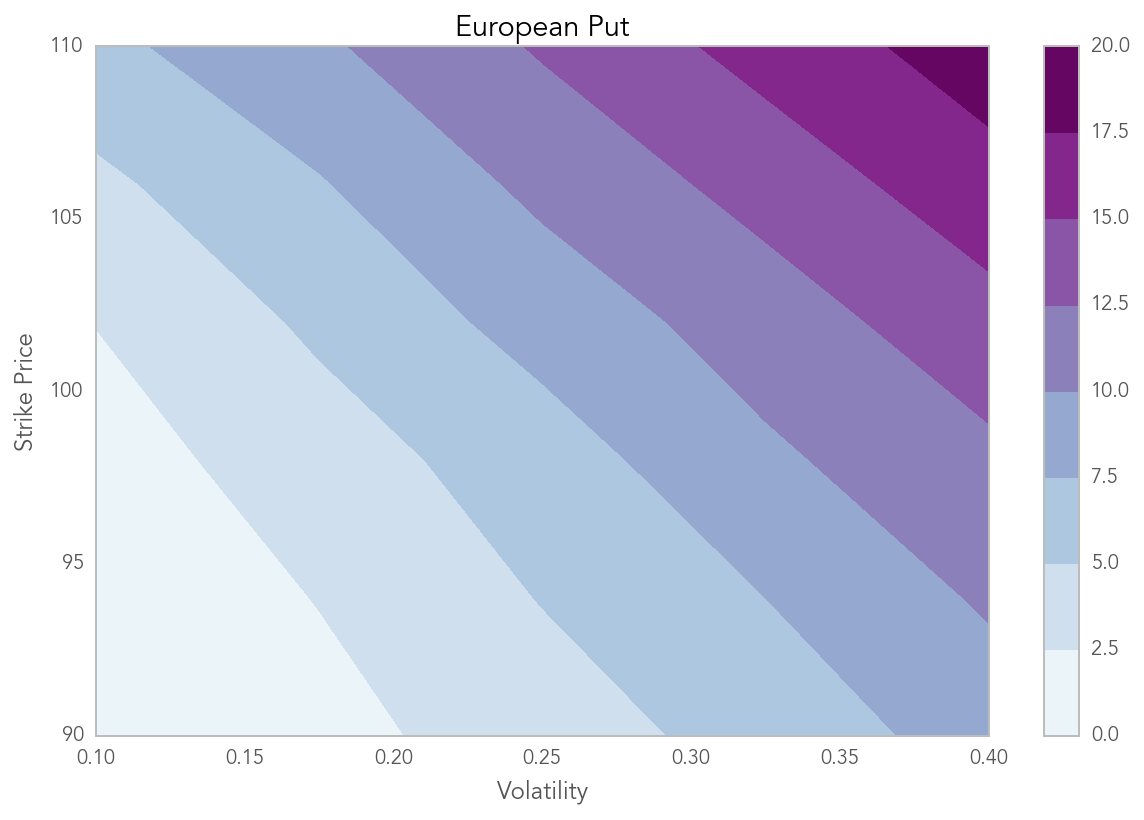

In [17]:
plt.figure()
plt.contourf(sigma_vals, strike_vals, prices['eput'])
plt.axis('tight')
plt.colorbar()
plt.title("European Put")
plt.xlabel("Volatility")
plt.ylabel("Strike Price")

Plot the value of the Asian put in (volatility, strike) space.

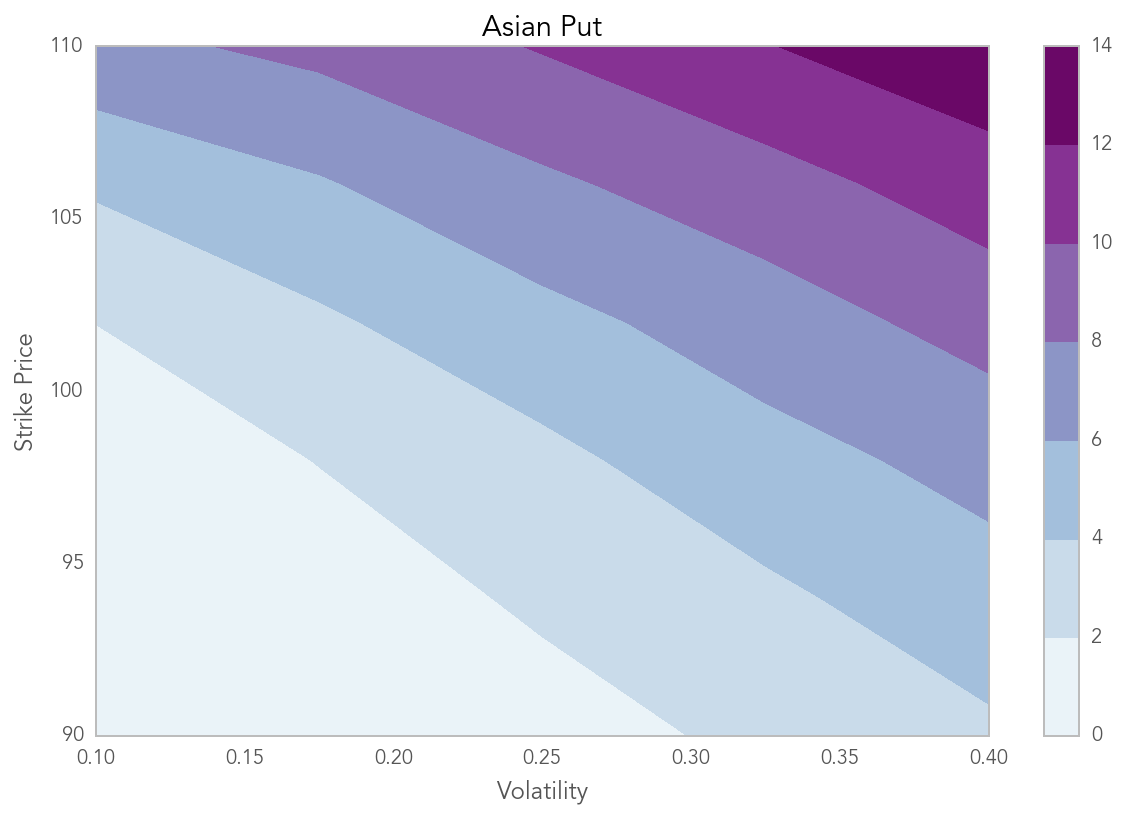

In [18]:
plt.figure()
plt.contourf(sigma_vals, strike_vals, prices['aput'])
plt.axis('tight')
plt.colorbar()
plt.title("Asian Put")
plt.xlabel("Volatility")
plt.ylabel("Strike Price")